### Protein Composition Statistics

The analysis functions are located in `./indels/proteins.py`, which draws general functions from `./indels/ind.py`

In [1]:
# Perform the initialization and imports
import sys
import pickle
import re
import os
import csv
import argparse
import math
import pprint

from string import ascii_lowercase
from collections import Counter, defaultdict, OrderedDict

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from Bio import SeqIO, AlignIO
from Bio.SeqRecord import SeqRecord
from Bio.Alphabet import IUPAC
from Bio.Seq import Seq
from Bio.Emboss.Applications import NeedleallCommandline

# Demand Python 3.
if sys.version_info[0] < 3:
    print("Python 3 is required, but you are using Python %i.%i.%i") % (
        sys.version_info[0], sys.version_info[1], sys.version_info[2])
    sys.exit(1)

If the InDelScanner directory is not on your path, modify the `indels_path` variable to point to it.

In [2]:
# Retrieve the specific functions from ind and proteins.py
indels_path="/home/maya/InDelScanner"  # /PATH/TO/InDelScanner
if indels_path not in sys.path:
    sys.path.append(indels_path)
#from indels.ind import trim_read, findEnds, endMatch, findGap, gapAlign

Specify the working directory: this should be where your input files are located.

In [3]:
os.chdir("/mnt/c/Users/Maya/Documents/03_Kinases/")

## Experiment design
In this experiment, the peptide libraries were split by FACS into three gates: high, medium and low. This DNA was isolated by PCR and sequenced in the same Illumina run. Due to initial low covereage of the "low" gate, this fraction was re-sequenced to yield "low-v2". The next cell loads the alignment dictionaries from both sequencing runs and combines into one Counter class.
Because of re-sequencing in the low fraction, we choose to combine the counts from both sequencing runs to take advantage of the total higher coverage.

### Library composition
The peptide libraries were randomized in the form MPKKKXTPXQXNXAPDGS; the randomized X positions are 6, 9, 11 and 13. Additionally, there is a possible insertion of A at position 7a (after TP) and a potential randomized X insertion at postion 8a. X may be any one of ADFGIKLMPVWY.

In [4]:
with open('mek.pickle', 'rb') as f:
    mek = pickle.load(f)

with open('kinases_all_ref.pickle', 'rb') as f:
    all_ref = pickle.load(f)

## Single position enrichments
The original protein before sorting is balanced: each randomized position contains an equal amount of each amino acid, as far as technically possible.

If a particular amino acid (for example, L in position 9) is adaptive for strong binding, the 'high' gate of the library should be enriched for that amino acid in that position. Hence, a deviation from balanced composition at any one position indicates that the enriched amino acids promote active binding while those depleted (and correspondingly enriched in the 'low' gate) are disruptive to binding.

In [5]:
def convert_variant_to_dict(mutation_string):
    """
    Convert a string of positions deviating from WT into a dictionary listing the status at all positions
    Input: string of the format '6A/7aK/9L' etc.
    Output: dictionary listing AA at each position, including WT
    """
    wt = {'6': 'P', '7a': 'Δ', '8a': 'Δ', '9': 'I', '11': 'L', '13': 'P'}
    
    mutation_list = mutation_string.split('/')
    m_by_pos = {point_mutation[:-1] : point_mutation[-1] for point_mutation in mutation_list}
    
    for position in wt.keys():   # need to do it this way so that WT positions are included
        try:
            m_by_pos[position]
        except KeyError:
            m_by_pos[position] = wt[position]

    return m_by_pos


def passes_restriction(m_by_pos, restrict):
    """
    Helper function in case we are looking at enrichment with certain positions fixed. 'restrict' is a dictionary of the form
    restrict[position] = ['A', 'L'] etc.
    """
    wt = {'6': 'P', '7a': 'Δ', '8a': 'Δ', '9': 'I', '11': 'L', '13': 'P'}
    
    if restrict:
        for position, allowed_aa in restrict.items():
            try:
                aa = m_by_pos[position]
            except KeyError:
                aa = wt[position]
            
            if aa not in allowed_aa:
                return False

    return True


def single_fraction_enrichment(mek, fraction, cutoff, restrict = False, proportion=True):
    """
    Input: the dictionary containing a Counter for each fraction
    Output: dictionary with data aggregated by position, format: point_distrubution[pos][aa] = int
    """
    valid_aa = {'A', 'D', 'F', 'G', 'I', 'K', 'L', 'M', 'P', 'V', 'W', 'Y', 'Δ'}
    point_distribution = {pos: {aa: 0 for aa in valid_aa} for pos in ['6', '7a', '8a', '9', '11', '13']}
    wt = {'6': 'P', '7a': 'Δ', '8a': 'Δ', '9': 'I', '11': 'L', '13': 'P'}

    # the input data is formatted as mek['fraction'][mutation_string] = integer
    # each mutation is a collection of mutations of the format Integer + single letterAA code, separated by '/'
    # we are querying this by position, so need to split by position and convert into a new Counter:
    # mek['fraction']['position']['amino_acid'] = integer
    
    for mutation_string, count in mek[fraction].items():
        if count > cutoff:  # ignore the frameshifts and such coming from noise
            
            # m_by_pos[position] = AA
            m_by_pos = convert_variant_to_dict(mutation_string)
            # check the mutations is one we're interested in
            observed_aa = set(m_by_pos.values())
            if not observed_aa.issubset(valid_aa):
                continue
            
            # in case we are considering relative enrichement, where some position is fixed:
            # the constrains has the form of a dictionary with allowed amino acids in tha tposition
            if not passes_restriction(m_by_pos, restrict):
                continue                

            # for the valid AAs, add counts to position proportions
            if proportion:
                for pos, aa in m_by_pos.items():  # need to do it this way so that WT positions are included
                    point_distribution[pos][aa] += count
            else:
                for pos, aa in m_by_pos.items():  # need to do it this way so that WT positions are included
                    point_distribution[pos][aa] += 1
    return point_distribution

In [6]:
# Set palette and the order of amino acids for meaningful colors
pal = sns.color_palette("tab20")[:13]
pal[12] = (0.9, 0.9, 0.9) # set deletion to gray
aa_order = ['A','G','P','Y','D','K','M','V','I','L','F','W','Δ']

In [7]:
def make_composition_plot_per_position(df_point, title_text, filename):
    sns.set_palette(pal)
    cols = df_point.columns.values.tolist()  
    aa_all = df_point.index.values.tolist()  # have the same labels and colorscheme for all charts

    fig = plt.figure(figsize=(13,2.5))
    fig.suptitle(title_text)

    axes = list(range(len(cols)))  # make axes with a column for each position

    for i in range(len(cols)):
        axes[i] = fig.add_subplot(1, len(cols), i + 1)
        plt.pie(df_point[cols[i]], startangle=90)
        axes[i].set_title(cols[i])

    markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in pal]
    fig.legend(markers, aa_all, numpoints=1, loc='center left', ncol=2)
    fig.patch.set_facecolor('white')
    
    plt.savefig(filename)

    plt.show()

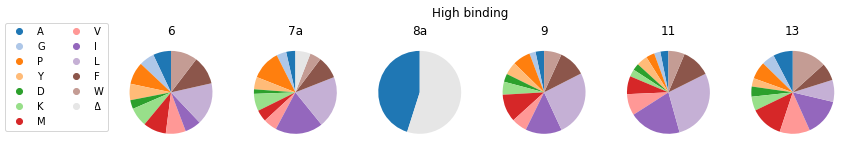

In [8]:
# Now use the distribution in this fraction to make plots
high = single_fraction_enrichment(mek, 'high', 10)
df_point_high = pd.DataFrame.from_dict(high).reindex(aa_order)
make_composition_plot_per_position(df_point_high, 'High binding', 'Piecharts_high_10.svg')

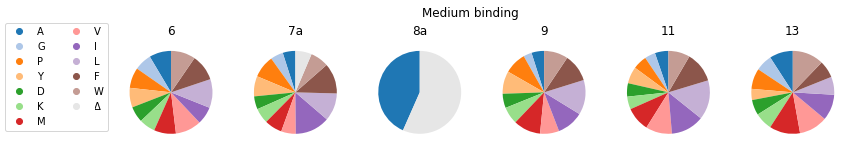

In [9]:
med = single_fraction_enrichment(mek, 'med', 5)
df_point_med = pd.DataFrame.from_dict(med).reindex(aa_order)
make_composition_plot_per_position(df_point_med, 'Medium binding', 'Piecharts_medium_5.svg')

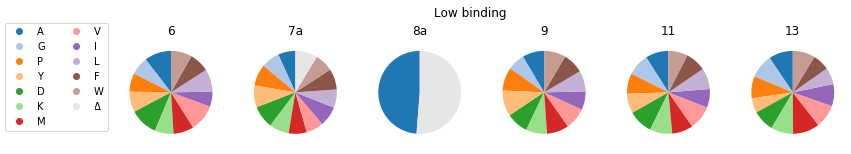

In [10]:
low = single_fraction_enrichment(mek, 'low-t', 3)
df_point_low = pd.DataFrame.from_dict(low).reindex(aa_order)
make_composition_plot_per_position(df_point_low, 'Low binding', 'Piecharts_low_3.svg')

### How many variants are there?

Now include filtering for variants with the correct codons

In [11]:
def filtered_counter(mek, fraction, cutoff, restrict = False):
    """
    Input: the dictionary containing a Counter for each fraction
    Output: dictionary with data aggregated by position, format: point_distrubution[pos][aa] = int
    """
    valid_aa = {'A', 'D', 'F', 'G', 'I', 'K', 'L', 'M', 'P', 'V', 'W', 'Y', 'Δ'}
    variants = defaultdict(int)
    wt = {'6': 'P', '7a': 'Δ', '8a': 'Δ', '9': 'I', '11': 'L', '13': 'P'}
    
    for mutation_string, count in mek[fraction].items():
        if count > cutoff:  # ignore the frameshifts and such coming from noise
            
            # m_by_pos[position] = AA
            m_by_pos = convert_variant_to_dict(mutation_string)
            # check the mutations is one we're interested in
            observed_aa = set(m_by_pos.values())
            if not observed_aa.issubset(valid_aa):
                continue
          
            variants[mutation_string] += count
    
    return Counter(variants)

In [12]:
def get_Venn_numbers(h, m, l):
    awyz = len(h)
    bwzx = len(m)
    cyzx = len(l)

    print('Total H:', awyz, 'Total M:', bwzx, 'Total L:', cyzx)
    un = len(h + m + l)
    print('Total all detected variants: {0}'.format(un))

    l_hm = len(h + m)
    l_ml = len(m + l)
    l_hl = len(l + h)


    ay = l_hm - bwzx
    bx = l_hm - awyz
    wz = l_hm - ay - bx

    aw = l_hl - cyzx
    cx = l_hl - awyz
    yz = l_hl - aw - cx

    bw = l_ml - cyzx
    cy = l_ml - bwzx
    xz = l_ml - bw - cy

    z = un - ay - cx - bw
    y = yz - z
    x = xz - z
    w = wz - z

    a = ay - y
    b = bx - x
    c = cy - y

    print('Venn values are a:{}, b:{}, c:{}, x:{}, y:{}, w:{}, z:{}, such that a total of {} variants are observed'.format(a, b, c, x, y, w, z, a+b+c+x+y+z+w))

In [13]:
# Venn diagram easy filtering
h = filtered_counter(mek, 'high', 10)
m = filtered_counter(mek, 'med', 5)
l = filtered_counter(mek, 'low-t', 3)

get_Venn_numbers(h, m, l)

Total H: 36401 Total M: 142971 Total L: 468041
Total all detected variants: 490306
Venn values are a:3472, b:15924, c:327486, x:110495, y:16377, w:2869, z:13683, such that a total of 490306 variants are observed


### Shannon Entropy (SE) at single positions
We often ask "How conserved is a position in an amino acid alignment?" Shannon entropy is a concept coming from information theory that gives a numerical description of conservation, with range from 0 (completely conserved) and 1 (no conservation). While the use of SE in protein sciece derives from analysis of protein sequence alignments, we can adapt SE for analysis of conservation in these sorted libraries by constructing "virtual multiple sequence alignment": each detected variant that has a count X above the cutoff is counted X-times, to weigh the amino acid distribution per position according to how frequent variants are. Therefore, the most strongly enriched variants also have the strongest effect on SE.

#### SE definitions
Single position Shannon entropy is defined as $$S_i = - \sum_{a=1}^{N} f_a \cdot log_N(f_a)$$
Frequency of amino acids: $$f_a = \frac{p + c_a}{n + 1}$$where $c_a$ is the number of amino acids $a$ at that position, $n$ is the total number of sequences and $p = \frac{1}{N}$ for alphabet of size $N$; here $N$ equals 2 (position 8a), 12 (positions 6, 9, 11 and 13) or 13 (positon 7a). 

#### Expectation: low conservation
In the graphs above we see that there is a shift in the distribution between the low, medium and high gates, but no amino acid dominates the outcome in the high gate. Hence, we expect that the conservation in terms of SE will be close to 1.

In [14]:
def Shannon_par(point_distribution, position):
    """
    Helper function to calculate Shannon pseudo-count
    :param point_distribution: calculated by single_fraction_enrichment
    :param position:
    :return:
    """
    N = 0  # size of amino acid alphabet
    n = 0  # total number of observed variants
    for aa, count in point_distribution[position].items():
        if count > 0:
            N += 1
            n += count

    p = 1/N

    return {'p': p, 'N': N, 'n': n}


def position_entropy(point_distribution, position):
    """
    Shannon entropy of a single position in protein alignment.
    :param point_distribution: calculated by single_fraction_enrichment
    :param position:
    :return:
    """
    # point_proportions has the structure point_proportions[pos][aa] = count
    S_i = 0
    par = Shannon_par(point_distribution, position)

    for aa, count in point_distribution[position].items():
        if count == 0:
            continue
        else:
            f_a = (par['p'] + count) / (par['n'] + 1)
            S_i -= f_a * math.log(f_a, par['N'])

    return S_i


In [15]:
low = single_fraction_enrichment(mek, 'low-t', 3, restrict = False, proportion=True)
for position in low.keys():
    print(position, position_entropy(low, position))

6 0.9935792970166224
7a 0.9983223273168654
8a 0.999562233543202
9 0.9980593760210932
11 0.9986204534384882
13 0.9947458953504762


In [16]:
med = single_fraction_enrichment(mek, 'med', 5, restrict = False, proportion=True)
for position in med.keys():
    print(position, position_entropy(med, position))

6 0.99259645650027
7a 0.9775768791554547
8a 0.9873417103202258
9 0.9763123190507657
11 0.9654168061944443
13 0.9826959301120625


In [17]:
high = single_fraction_enrichment(mek, 'high', 10, restrict = False, proportion=True)
for position in high.keys():
    print(position, position_entropy(high, position))

6 0.9732332372470396
7a 0.913549767397763
8a 0.993028420504394
9 0.907801004658813
11 0.8611495905619317
13 0.9601108094611331
